# Kilonova Class

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
import random
import itertools
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
#We will need to grab the data from where it is saved on the computer.

#NS-NS
APR1215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt')
APR1314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt')
H41215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt')
H41314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt')
Sly135 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt')

#NS-BH
APR4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt')
H4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt')
MS1Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt')
MS1Q7a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt')

In [2]:
class kilonova(object):
    
    def __init__(self, merger, name):
    '''
    A Merger is a table of varying magnitudes representing a kilonova light curve in five different
        filters (u, g, r, i, z).
    A Name is a string representing the theoretical kilonova light curve's object ID.
    Results are different information about the kilonova (e.g. light curves, discovery metrics, etc.).
    
    kilonova: Merger Name -> Results
    
    This class takes in a kilonova with an object id and runs different tests on the kilonova
    (e.g. light curves, discovery metrics, etc.).
    '''
        self.merger = merger
        self.name = name

#________________________________________________________________________________________________________________

#
#
# CONSTANTS, APPARENT MAGNITUDE CALCULATIONS, AND KILONOVA LIGHT CURVES
#
#


#
# Constants:
#

    
# Discovery Metrics
'''
sigma_sys: the systematic error of the LSST
trial_num: the number of trials in the simulations for the discovery metrics
t_vis: the visibility time of the LSST
parameters: table representing different conditions of the LSST for each of the five filters
'''
    sigma_sys = 0.005
    trial_num = 5000
    t_vis = 30
    parameters = Table([['m_sky', 'theta', 'gamma', 'k_m', 'C_m', 'm_5', 'del_C', 'del_C2', 'del_m_5'],
                        [22.9, 0.77, 0.037, 0.451, 22.92, 23.68, 0.67, 0.24, 0.21],
                        [22.3, 0.73, 0.038, 0.163, 24.29, 24.89, 0.21, 0.09, 0.15],
                        [21.2, 0.70, 0.039, 0.087, 24.33, 24.43, 0.11, 0.05, 0.14],
                        [20.5, 0.67, 0.039, 0.065, 24.20, 24.00, 0.08, 0.04, 0.13], 
                        [19.6, 0.65, 0.040, 0.043, 24.07, 24.45, 0.05, 0.03, 0.13],
                        [18.6, 0.63, 0.040, 0.138, 23.69, 22.60, 0.04, 0.02, 0.15,]],
                      names = ('parameters','u', 'g', 'r', 'i', 'z', 'y'))
    
    
# Light Curve Constants
'''
title: the font size for the title of a graph
subtitle: the font size for the subtitle of a graph
axis: the font size for the axis of a graph
ticksize: the size for the axis ticks of a graph
legend: the font size for the legend of a graph
'''
    title = 26
    subtitle = 24
    axis = 20
    ticksize = 14
    legend = 14


    
#
# Apparent Magnitude Calculations
#
'''
A Distance is a Number that is measured in Mpc.
A Redshift is a Number indicating the distance of an object by how much the light of the object has redshifted.
A Magnitude is a Number indicating the brightness of an object measured on earth.
A Band is a String; each band represents the specific filter that LSST will use (u,z,r,i,z,y).
'''


# Megaparsecs

    def app_mag_dist(self, distance):
        '''
        app_mag: Merger Distance -> Merger
        Converts the merger data from absolute magnitude to apparent magnitude depending on the distance (Mpc).
        '''
        self.distance = distance
        day=self.merger['day']
        u=self.app_mag_band_dist('u')
        g=self.app_mag_band_dist('g')
        r=self.app_mag_band_dist('r')
        i=self.app_mag_band_dist('i')
        z=self.app_mag_band_dist('z')
        return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))


    def app_mag_band_dist(self, band):
        '''
        app_mag_band: Magnitude Distance String -> Magnitude
        Converts the absolute magnitude into an apparent magnitude dpending on the distance and the band filter.
        '''
        self.band = band
        app_mag = 5*np.log10((self.distance*1e6)/10)+self.merger[self.band]
        return app_mag


# Redshift

    def app_mag_redshift(self, redshift):
        '''
        app_mag_redshift: Merger Number -> Merger
        Converts the merger data from absolute magnitude to apparent magnitude depending on the redshift.
        '''
        self.redshift = redshift
        day=self.merger['day']
        u=self.app_mag_band_redshift('u')
        g=self.app_mag_band_redshift('g')
        r=self.app_mag_band_redshift('r')
        i=self.app_mag_band_redshift('i')
        z=self.app_mag_band_redshift('z')
        return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

    
    def app_mag_band_redshift(self, band):
        '''
        app_mag_band: Magnitude Redshift Band -> Magnitude
        Converts the absolute magnitude into an apparent magnitude dpending on the redshift and the band filter.
        '''
        self.band = band
        app_mag = 5*np.log10(self.lumo_dist()/10)+self.merger[self.band]
        return app_mag


    def lumo_dist(self):
        '''
        lumo_dist: Reshift -> Distance
        Converts redshift to luminosity distance.
        '''
        return cosmo.luminosity_distance(self.redshift).to(astro.units.pc).value
        
#________________________________________________________________________________________________________________
        
#
#
# LSST DISCOVERY METRICS & CALCULATIONS
#    
#  



class discovery_metrics(kilonova):
    
    def __init__(self, kilonova):
        '''
        discovery_metrics: kilonova -> Results
    
        This class takes in a kilonova with an object id and runs basic discovery metrics that we would expect
        LSST to use to discover kilonovae.
        '''
        self.merger = kilonova.merger
        
    
#
# Discovery Metrics
#

'''
The discovery metrics we are using are simple criteria used to simulate what LSST would use to discover kilonoae
in the sky. The metrics use two major characteristics of kilonovae--short visibility time and low
temperature explosion--to distiguish them from other transient sources. These metrics use change in magnitude
(difference in magnitude of a single band at different time periods, denoted "del-mag") and color (difference
in magnitude between two bands at a single time, denoted "f-z" where f is all bands except for z) to run simple
"discovery metric criteria" of what we believe to be the optimal way to discover a kilonova. Right now the
metrics are quite simple, but in the future we will work to make the tests more complex and realistic to what
the telescope will face in Chile.

Each discovery metric have the following assumptions:
- Maximum of 4 observations by LSST.
- First observation happens at a random time in a 24-hour period (Epoch 1).
- If LSST cannot observe due to bad weather (20% probability), then it will observe 24 hours later.
- The farther away the kilonova is, the harder it is for LSST to detect it.
'''

# 1-day Discovery Metric (1-day)

    def one_day(self):
        '''
        one_day: kilonova -> 1-day discovery metric

        Note: A 1-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 1-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        Epoch 1:
            - f-z > 0.5 with signal-to-noise > 3
        
        Epoch 2 (Epoch 1 + 1 Day):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 0.5 with signal-to-noise > 3
        
        OR
        
        Epoch 1:
            - f-z < -0.5 with a signal-to-noise > 3:
        
        Epoch 2 (Epoch 1 + 1 Day):
            - f-z > 1 with signal-to-noise > 3
            - del-mag of z-band < 0.2 with signal-to-noise > 3
        '''
        time = self.weather_output1()
        distances0 = self.rand_dists()
        colors = self.measure_color1(time, distances0)
        distances = colors['Distance (Mpc)']
        discoveries = []
        for i in range(len(colors['Color (Epoch 1)'])):

            if colors['Color (Epoch 1)'][i] > 0.5 and \
            np.divide(colors['Color (Epoch 1)'][i], colors['Sigmas (Epoch 1)'][i]) > 3:
                if colors['Color (Epoch 2)'][i] > 0.5 and \
                np.divide(colors['Color (Epoch 2)'][i], colors['Sigmas (Epoch 2)'][i]) > 3 and \
                colors['$\Delta m_{1}$ (z-band)'][i] > 0.5 and \
                np.divide(colors['$\Delta m_{1}$ (z-band)'][i], colors['Sigmas (z-band)'][i]) > 3:
                    discoveries.append(1)
                else:
                    discoveries.append(0)

            elif colors['Color (Epoch 1)'][i] < -0.5 and \
            np.divide(colors['Color (Epoch 1)'][i], colors['Sigmas (Epoch 1)'][i]) > 3:
                if colors['$\Delta m_{1}$ (u,g,r,i-bands)'][i] > 1 and \
                np.divide(colors['$\Delta m_{1}$ (u,g,r,i-bands)'][i], 
                          colors['Sigmas (u,g,r,i-bands)'][i]) > 3 and \
                colors['$\Delta m_{1}$ (z-band)'][i] < 0.2 and \
                np.divide(colors['$\Delta m_{1}$ (z-band)'][i], colors['Sigmas (z-band)'][i]) > 3:
                    discoveries.append(1)
                else:
                    discoveries.append(0)
            else:
                discoveries.append(0)

        return Table([colors['Band'], distances, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))
    
    
    
# 3-day Discovery Metric (3-day)
    
    def three_day(self):
        '''
        three_day: kilonova -> 3-day discovery metric

        Note: A 3-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 3-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        Epoch 1:
            - f-z > 0.5 with signal-to-noise > 3
        
        Epoch 2 (Epoch 1 + 3 Days):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 1 with signal-to-noise > 3
        '''
        time = self.weather_output3()
        distances0 = self.rand_dists()
        colors = self.measure_color3(time, distances0)
        distances = colors['Distance (Mpc)']
        discoveries = []
        for i in range(len(colors['Color (Epoch 1)'])):
            
            if colors['Color (Epoch 1)'][i] > 0.5 and \
            np.divide(colors['Color (Epoch 1)'][i], colors['Sigmas (Epoch 1)'][i]) > 3 and \
            colors['Color (Epoch 2)'][i] > 0.5 and \
            np.divide(colors['Color (Epoch 2)'][i], colors['Sigmas (Epoch 2)'][i]) > 3 and \
            colors['$\Delta m_{3}$ (z-band)'][i] > 1.0 and \
            np.divide(colors['$\Delta m_{3}$ (z-band)'][i], colors['Sigmas (z-band)'][i]) > 3:
                discoveries.append(1)
            else:
                discoveries.append(0)

        return Table([colors['Band'], distances, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))

    
    
# 7-day Discovery Metric (7-day)
    
    def seven_day(self):
        '''
        seven_day: kilonova -> 7-day discovery metric

        Note: A 7-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 7-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        Epoch 1:
            - measure z-band
        
        Epoch 2 (Epoch 1 + 7 Days):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 1 with signal-to-noise > 3
        '''
        time = self.weather_output7()
        distances0 = self.rand_dists()
        colors = self.measure_color7(time, distances0)
        discoveries = []
        distance = colors['Distance (Mpc)']
        for i in range(len(colors['Color (Epoch 2)'])):
            
            if colors['Color (Epoch 2)'][i] > 0.5 and \
            np.divide(colors['Color (Epoch 2)'][i], colors['Sigmas (Epoch 2)'][i]) > 3 and \
            colors['$\Delta m_{7}$ (z-band)'][i] > 1.0 and \
            np.divide(colors['$\Delta m_{7}$ (z-band)'][i], colors['Sigmas (z-band)'][i]) > 3:
                discoveries.append(1)
            else:
                discoveries.append(0)
                
        return Table([colors['Band'], distance, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))
    
#----------------------------------------------------------------------------------------------------------------

#
# Color/Delta-Mag. Calculations
#
    
    
# 1-day

    def measure_color1(self, time0, distances0):
        '''
        measure_color1
        '''
        u = self.measure_color_band1(time0, distances0, 'u')
        g = self.measure_color_band1(time0, distances0, 'g')
        r = self.measure_color_band1(time0, distances0, 'r')
        i = self.measure_color_band1(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band1(self, time0, distances0, band):
        color_list1 = []
        color_sigs1 = []
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_mag = []
        delta_sigma = []
        delta_z = []
        sig_z = []

        for t1,t2,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #color, delta-z, and sigma calculations
            mag1 = self.get_mag(merger, band, t1, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)

            sig1 = self.sigma_1(mag1, band, X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)

            color1 = np.subtract(mag1,z1)
            sigs1 = np.sqrt(np.add(np.square(sig1), np.square(sigz1)))
            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            dmag = np.subtract(mag2, mag1)
            dmagsig = np.sqrt(np.add(np.square(sig1), np.square(sig2)))
            z = np.subtract(z2,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz2)))

            #append lists
            color_list1.append(color1)
            color_sigs1.append(sigs1)
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_mag.append(dmag)
            delta_sigma.append(dmagsig)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list1, color_list2, color_sigs1, color_sigs2,
                      delta_mag, delta_z, delta_sigma, sig_z],
                     names=('Band', 'Distance (Mpc)','Color (Epoch 1)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{1}$ (u,g,r,i-bands)',
                            '$\Delta m_{1}$ (z-band)', 'Sigmas (u,g,r,i-bands)', 'Sigmas (z-band)'))
    
    
# 3-day    
    
    def measure_color3(self, time0, distances0):
        u = self.measure_color_band3(time0, distances0, 'u')
        g = self.measure_color_band3(time0, distances0, 'g')
        r = self.measure_color_band3(time0, distances0, 'r')
        i = self.measure_color_band3(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band3(self, time0, distances0, band):
        color_list1 = []
        color_sigs1 = []
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_z = []
        sig_z = []

        for t1,t2,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #color, delta-z, and sigma calculations
            mag1 = self.get_mag(merger, band, t1, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)

            sig1 = self.sigma_1(mag1, band, X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)

            color1 = np.subtract(mag1,z1)
            sigs1 = np.sqrt(np.add(np.square(sig1), np.square(sigz1)))
            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            z = np.subtract(z2,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz2)))

            #append lists
            color_list1.append(color1)
            color_sigs1.append(sigs1)
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list1, color_list2, color_sigs1, color_sigs2, delta_z, sig_z],
                     names=('Band', 'Distance (Mpc)','Color (Epoch 1)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{3}$ (z-band)',
                            'Sigmas (z-band)'))
    
# 7-day

    def measure_color7(self, time0, distances0):
        u = self.measure_color_band7(time0, distances0, 'u')
        g = self.measure_color_band7(time0, distances0, 'g')
        r = self.measure_color_band7(time0, distances0, 'r')
        i = self.measure_color_band7(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band7(self, time0, distances0, band):  
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_z = []
        sig_z = []

        for t1,t2,t7,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], time0['Epoch 3'],
                                                   distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #colors, sigmas, and delta-z calculations
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            z7 = self.get_mag(merger, 'z', t7, LSST, X, self.t_vis)
            
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sigz7 = self.sigma_1(z7, 'z', X, self.t_vis)

            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            z = np.subtract(z7,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz7)))

            #list appends
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list2, color_sigs2, delta_z, sig_z],
                     names=('Band', 'Distance (Mpc)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 2)', '$\Delta m_{7}$ (z-band)', 'Sigmas (z-band)'))
    
    
#----------------------------------------------------------------------------------------------------------------

#
# Time Calculations (with weather incorporated)
#

    def weather_output1(self):
        t1 = []
        t2 = []
        for i in range(self.trial_num):
            t = random.random()+1.06
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+1)
            t1.append(t01)
            t2.append(t02)
        return {'Epoch 1': t1, 'Epoch 2': t2} 
    
    
    def weather_output3(self):
        t1 = []
        t2 = []
        for i in range(self.trial_num):
            t = random.random()+1.06
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+3)
            t1.append(t01)
            t2.append(t02)
        return {'Epoch 1': t1, 'Epoch 2': t2}
    

    def weather_output7(self):
        t1 = []
        t2 = []
        t7 = []
        for i in range(self.trial_num):
            t = random.random()+1.06
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+3)
            t07 = self.weather_simulator(t01+7)
            t1.append(t01)
            t2.append(t02)
            t7.append(t07)
        return {'Epoch 1': t1, 'Epoch 2': t2, 'Epoch 3': t7}
    
#----------------------------------------------------------------------------------------------------------------

#
# Additional Functions
#
    
    
# Weather:

    def weather_simulator(self, time):
        weather = random.random()
        if weather < 0.8:
            time = time
        else:
            time = self.weather_simulator(time+1)
        return time
    

# Distances:

    def rand_dists(self):
        distances = []
        for i in range(self.trial_num):
            distances.append(self.rand_dist())
        return distances

    #rand_dist: Merger -> Number
    #Picks a random distance from 0 to 200Mpc.
    def rand_dist(self):
        x=random.uniform(-1,1)
        y=random.uniform(-1,1)
        z=random.uniform(-1,1)
        dist=np.sqrt(x**2+y**2+z**2)
        if dist < 1:
            return dist*200
        else:
            return self.rand_dist()
        return

    
# Magnitude Calculations:    
    
    def get_mag(self, merger, band, time, LSST, X=1, t_vis=30):
        mag=0
        if self.detect(merger, band, time, LSST, X, t_vis)==True:
            if band == 'u':
                mag = self.rand_mag(merger, band, time, 0, X, self.t_vis)
            elif band == 'g':
                mag = self.rand_mag(merger, band, time, 1, X, self.t_vis)
            elif band == 'r':
                mag = self.rand_mag(merger, band, time, 2, X, self.t_vis)
            elif band == 'i':
                mag = self.rand_mag(merger, band, time, 3, X, self.t_vis)
            elif band == 'z':
                mag = self.rand_mag(merger, band, time, 4, X, self.t_vis)

        elif self.detect(merger, band, time, LSST, X, self.t_vis)==False:
            mag = LSST[band]

        return mag
    
    
    #detect: Merger String Number -> Boolean
    #Determines if LSST can detect the light curve of a specific band at a specific time.
    def detect(self, merger, band, time, LSST, X=1, t_vis=30):
        if band == 'u':
            mag_u = self.rand_mag(merger, band, time, 0, X, t_vis)
            return self.in_view(mag_u, LSST['u'])
        elif band == 'g':
            mag_g = self.rand_mag(merger, band, time, 1, X, t_vis)
            return self.in_view(mag_g, LSST['g'])
        elif band == 'r':
            mag_r = self.rand_mag(merger, band, time, 2, X, t_vis)
            return self.in_view(mag_r, LSST['r'])
        elif band == 'i':
            mag_i = self.rand_mag(merger, band, time, 3, X, t_vis)
            return self.in_view(mag_i, LSST['i'])
        elif band == 'z':
            mag_z = self.rand_mag(merger, band, time, 4, X, t_vis)
            return self.in_view(mag_z, LSST['z'])
        return
    
    
    #in_view: Number Number -> Boolean
    #Checks if LSST can detect the light curve based on magnitude.
    def in_view(self, mag, LSST):
        if mag < LSST:
            return True
        else:
            return False
        return
    
    
    def rand_mag(self, merger, band, day, number, X=1, t_vis=30):
        max_depth = self.m_5(band, self.parameters, X, t_vis)
        if self.interpolate(merger, X, t_vis)[number](day) > max_depth:
            m_true = max_depth

        else:
            m_true = self.interpolate(merger, X, t_vis)[number](day)

        stdev = self.sigma_1(m_true, band)        

        if m_true == max_depth:
            m_obs = max_depth
        else:
            m_obs = np.random.normal(m_true, stdev)
        return m_obs
    

    #interpolate: Merger-> List of Interpolations
    #Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
    def interpolate(self, merger, X=1, t_vis=30):
        LSST_u=self.m_5('u', self.parameters, X, self.t_vis)
        LSST_g=self.m_5('g', self.parameters, X, self.t_vis)
        LSST_r=self.m_5('r', self.parameters, X, self.t_vis)
        LSST_i=self.m_5('i', self.parameters, X, self.t_vis)
        LSST_z=self.m_5('z', self.parameters, X, self.t_vis)
        approx='cubic'
        u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
                   kind=approx, bounds_error=False, fill_value=LSST_u)
        g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
                   kind=approx, bounds_error=False, fill_value=LSST_g)
        r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
                   kind=approx, bounds_error=False, fill_value=LSST_r)
        i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
                   kind=approx, bounds_error=False, fill_value=LSST_i)
        z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
                   kind=approx, bounds_error=False, fill_value=LSST_z)
        return [u, g, r, i, z]
    
    
    
# Sigma Calculation:
    
    def sigma_1(self, mag, band, X=1, t_vis=30):
        sigma1 = np.float(np.sqrt(self.sigma_sys**2 + self.sigma_rand(mag, band, self.parameters, X, t_vis)**2))
        return sigma1


    def sigma_rand(self, mag, band, parameters, X=1, t_vis=30):
        gamma = parameters[band][np.where(parameters['parameters']=='gamma')]
        return np.float((0.04-gamma)*self.x(mag, band, parameters, X, t_vis) + gamma*self.x(mag, 
                                                                                            band, 
                                                                                            parameters, 
                                                                                            X, t_vis)**2)

    def x(self, mag, band, parameters, X=1, t_vis=30):
        return np.float(10**(0.4*(mag-self.m_5(band, parameters, X, t_vis))))

    
    def m_5(self, band, parameters, X=1, t_vis=30):
        C_m = parameters[band][np.where(parameters['parameters']=='C_m')]
        m_sky = parameters[band][np.where(parameters['parameters']=='m_sky')]
        theta = parameters[band][np.where(parameters['parameters']=='theta')]
        k_m = parameters[band][np.where(parameters['parameters']=='k_m')]
        m_5 = C_m+0.50*(m_sky-21)+2.5*np.log10(0.7/theta)+1.25*np.log10(t_vis/30)-k_m*(X-1)
        return np.float(m_5)
    
    
#________________________________________________________________________________________________________________


#
#
# EFFICIENCY PLOTS
#
#

    
class efficiency_plots(discovery_metrics):
    
    def __init__(self, table):
        self.table = table
        

#
# Constants
#


# Light Curve Constants
    title = 26
    subtitle = 24
    axis = 20
    ticksize = 14
    legend = 14
               

        
        
#
# Efficiency Plots
#


    #plot_bar: Table String -> Image
    #Plots a bar graph of the efficiency of the LSST as a function of distance(Mpc).
    def plot(self):
        plt.figure(figsize=(10,11))
        ax1 = plt.subplot(411)
        ax1b = ax1.twinx()
        ax2 = plt.subplot(412)
        ax2b = ax2.twinx()
        ax3 = plt.subplot(413)
        ax3b = ax3.twinx()
        ax4 = plt.subplot(414)
        ax4b = ax4.twinx()

#****************************************************************************************************************

        n1b, bins1b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'u-z'))), 
                                 bins = 50, range=(0,200))

        center1 = (self.efficiency(self.table, 'u-z')[1][:-1] + self.efficiency(self.table, 'u-z')[1][1:]) / 2
        width1 = (self.efficiency(self.table, 'u-z')[1][1] - self.efficiency(self.table, 'u-z')[1][0])

        ax1.bar(center1, self.efficiency(self.table, 'u-z')[0],
               width=width1, align='center', facecolor='blue', edgecolor='black', label='Efficiency')
        ax1b.plot(center1, n1b, 'o-', color='orange', markeredgecolor='black', label='Total\nKilonovae')


        handles1,labels1 = ax1b.get_legend_handles_labels()

        handles1 =handles1[::-1]
        labels1 = labels1[::-1]   

        ax1.legend(handles1, labels1, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size': self.legend})

        ax1.set_title('u $-$ z', fontsize=self.subtitle)
        ax1.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax1.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax1.tick_params(labelsize=self.ticksize)
        ax1b.tick_params(labelsize=self.ticksize)
        ax1.set_ylim(0,100)
        ax1b.set_ylim(0, self.rounded_up(max(n1b)))
        ax1b.set_ylabel('Kilonovae', fontsize=self.axis)

#****************************************************************************************************************

        n2b, bins2b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'g-z'))), 
                                 bins = 50, range=(0,200))

        center2 = (self.efficiency(self.table, 'g-z')[1][:-1] + self.efficiency(self.table, 'g-z')[1][1:]) / 2
        width2 = (self.efficiency(self.table, 'g-z')[1][1] - self.efficiency(self.table, 'g-z')[1][0])

        ax2.bar(center2, self.efficiency(self.table, 'g-z')[0],
                width=width2, align='center', facecolor='green', edgecolor='black', label='Efficiency')
        ax2b.plot(center2, n2b, 'o-', color='red', markeredgecolor='black', label='Total\nKilonovae')



        handles2,labels2 = ax2b.get_legend_handles_labels()

        handles2 =handles2[::-1]
        labels2 = labels2[::-1]

        ax2.legend(handles2, labels2, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size': self.legend})

        ax2.set_title('g $-$ z', fontsize=self.subtitle)
        ax2.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax2.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax2.tick_params(labelsize=self.ticksize)
        ax2b.tick_params(labelsize=self.ticksize)
        ax2.set_ylim(0,100)
        ax2b.set_ylim(0, self.rounded_up(max(n2b)))
        ax2b.set_ylabel('Kilonovae', fontsize=self.axis)

#****************************************************************************************************************

        n3b, bins3b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'r-z'))), 
                                 bins = 50, range=(0,200))

        center3 = (self.efficiency(self.table, 'r-z')[1][:-1] + self.efficiency(self.table, 'r-z')[1][1:]) / 2
        width3 = (self.efficiency(self.table, 'r-z')[1][1] - self.efficiency(self.table, 'r-z')[1][0])

        ax3.bar(center3, self.efficiency(self.table, 'r-z')[0],
                width=width3, align='center', facecolor='yellow', edgecolor='black', label='Efficiency')
        ax3b.plot(center3, n3b, 'o-', color='violet', markeredgecolor='black', label='Total\nKilonovae')


        handles3,labels3 = ax3b.get_legend_handles_labels()

        handles3 =handles3[::-1]
        labels3 = labels3[::-1]

        ax3.legend(handles3, labels3, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size':self.legend})

        ax3.set_title('r $-$ z', fontsize=self.subtitle)
        ax3.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax3.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax3.tick_params(labelsize=self.ticksize)
        ax3b.tick_params(labelsize=self.ticksize)
        ax3.set_ylim(0,100)
        ax3b.set_ylim(0, self.rounded_up(max(n3b)))
        ax3b.set_ylabel('Kilonovae', fontsize=self.axis)


#****************************************************************************************************************
        n4b, bins4b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'i-z'))), 
                                 bins = 50, range=(0,200))

        center4 = (self.efficiency(self.table, 'i-z')[1][:-1] + self.efficiency(self.table, 'i-z')[1][1:]) / 2
        width4 = (self.efficiency(self.table, 'i-z')[1][1] - self.efficiency(self.table, 'i-z')[1][0])

        ax4.bar(center4, self.efficiency(self.table, 'i-z')[0],
                width=width4, align='center', facecolor='orange', edgecolor='black', label='Efficiency')
        ax4b.plot(center4, n4b, 'o-', color='turquoise', markeredgecolor='black', label='Total\nKilonovae')

        handles4,labels4 = ax4b.get_legend_handles_labels()

        handles4 =handles4[::-1]
        labels4 = labels4[::-1]

        ax4.legend(handles4, labels4, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size':self.legend})

        ax4.set_title('i $-$ z', fontsize=self.subtitle)
        ax4.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax4.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax4.tick_params(labelsize=self.ticksize)
        ax4b.tick_params(labelsize=self.ticksize)
        ax4.set_ylim(0,100)
        ax4b.set_ylim(0, self.rounded_up(max(n4b)))
        ax4b.set_ylabel('Kilonovae', fontsize=self.axis)

#****************************************************************************************************************

        #plt.suptitle(name+" Efficiency Plot", fontsize=title, y=1.05, horizontalalignment='center')
        plt.tight_layout()
        return
    

#
# Calculations
#
    

    #efficiency: Table String -> ListofNumbers
    #Converts the number of detections into a fraction: number of succesful detections over the total number of
    # observations at that distance.
    def efficiency(self, table, band):
        countx, binx=np.histogram(np.array(self.filter_dist(self.filter_band(self.filter_hits(table)
                                                                             , band))),
                                  bins=50, range=(0,200))
        county, biny=np.histogram(np.array(self.filter_dist(self.filter_band(table, band))),
                                  bins=50, range=(0,200))
        np.seterr(divide='ignore', invalid='ignore')
        counts=countx/county
        for i in range(len(counts)):
            if np.isnan(counts[i]):
                counts[i]=0
        return counts*100, binx
    
    
    #filter_hits: Table -> Table
    #Filters the table to only have data containing kilonova hits.
    def filter_hits(self, table):
        hits = np.where(table['Discovery'] == 1)[0]
        return table[hits]
    

    #filter_band: Table String -> Table
    #Filters the table to only have data containing the designated band.
    def filter_band(self, table,  band):
        band_filter=np.where(table['Band']==band)[0]
        return table[band_filter]
    

    #filter_hits: Table -> Table
    #Filters the table to only have data containing the distance (Mpc).
    def filter_dist(self, table):
        return table['Distance (Mpc)']
    

    #round_up: number base -> number
    #Rounds the number up to the nearest multiple of the base number.
    def rounded_up(self, x, base=5):
        return int(base * (round(float(x)/base)+1))

In [3]:
#NS-NS
APR1215 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt'),
                   "APR4-1215")
APR1314 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt'),
                   "APR4-1314")
H41215 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt'),
                  "H4-1215")
H41314 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt'),
                  "H4-1314")
Sly135 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt'),
                  "Sly-135")

#NS-BH
APR4Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt'),
                     "APR4Q3a75")
H4Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt'),
                   "H4Q3a75")
MS1Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt'),
                    "MS1Q3a75")
MS1Q7a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt'),
                    "MS1Q7a75")

In [4]:
APR1215_table1 = discovery_metrics(APR1215).one_day()

In [5]:
APR1215_table3 = discovery_metrics(APR1215).three_day()

In [6]:
APR1215_table7 = discovery_metrics(APR1215).seven_day()

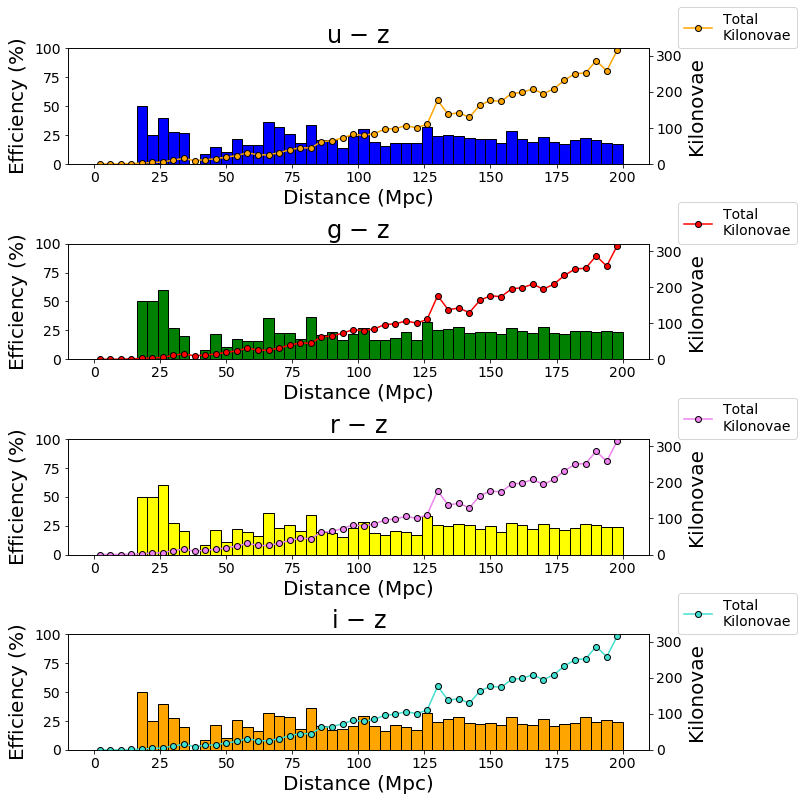

In [7]:
efficiency_plots(APR1215_table1).plot()

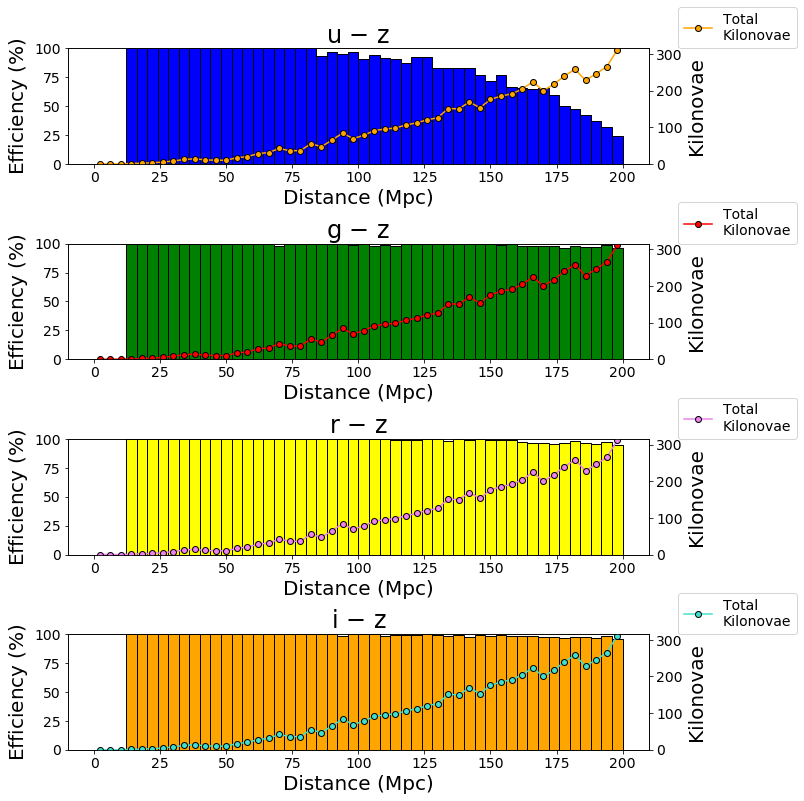

In [8]:
efficiency_plots(APR1215_table3).plot()

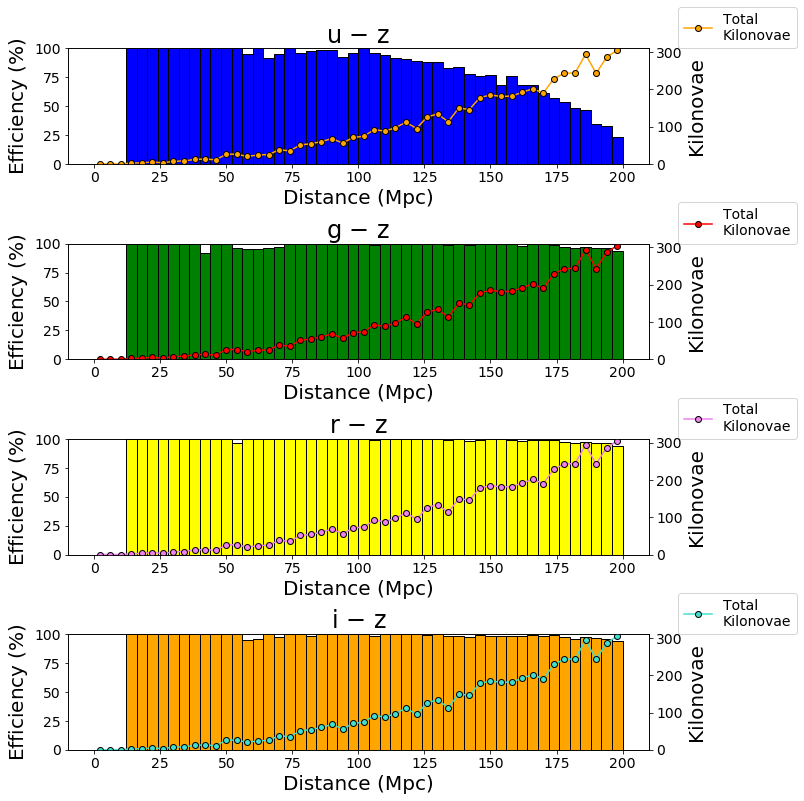

In [9]:
efficiency_plots(APR1215_table7).plot()